In [24]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import random
import yfinance as yf
from scipy import stats
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
import pandas as pd
import pylab

import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

In [5]:
trayectorias = 10000
puntos = 252
delta_t = 1/puntos
t = np.linspace(0,1,puntos+1)
mu=1
sigma=0.1
s0=1

In [6]:
def MBEU(numTrayectorias, numPuntos):
  delta_t = 1/numPuntos
  mb = np.zeros((numTrayectorias, numPuntos+1))
  for i in range(numTrayectorias):
    for j in range(1, numPuntos+1):
      mb[i,j] = mb[i,j-1] + np.sqrt(delta_t) * np.random.normal(0, 1)
  return mb

In [7]:
def euler_maruyama(numTrayectorias, numPuntos,mb,s0, mu, sigma):
  delta_t = 1/numPuntos
  st= np.zeros((numTrayectorias,numPuntos+1))
  st[:,0]= s0

  for i in range(numTrayectorias):
    for j in range(1,numPuntos+1):
      st[i,j]= st[i,j-1] + mu*st[i,j-1]*delta_t +sigma*st[i,j-1]*(mb[i,j]-mb[i,j-1])
  return st

In [8]:
def milstein(numTrayectorias, numPuntos,mb,s0, mu, sigma):
  delta_t = 1/numPuntos
  st= np.zeros((numTrayectorias,numPuntos+1))
  st[:,0]= s0

  for i in range(numTrayectorias):
    for j in range(1,numPuntos+1):
      st[i,j]= st[i,j-1] + mu*st[i,j-1]*delta_t +sigma*st[i,j-1]*(mb[i,j]-mb[i,j-1]) + (1/2)*(sigma**2)*st[i,j-1]*((mb[i,j]-mb[i,j-1])**2-delta_t)
  return st

In [9]:
def solucion_explicita(numTrayectorias, numPuntos, mb,s0,mu,sigma):
  delta_t= 1/numPuntos
  solucion= np.zeros((numTrayectorias, numPuntos+1))
  solucion[:,0]= s0
  for i in range(numTrayectorias):
    for j in range(1,numPuntos+1):
      solucion[i,j]= solucion[i,j-1]* np.exp( (mu-(1/2)*sigma**2)*delta_t + sigma*(mb[i,j]-mb[i,j-1])) 
  return solucion

In [10]:
#comparaciones entre las aproximaciones y la solución explícita
mb= MBEU(trayectorias,puntos)
sol= solucion_explicita(trayectorias,puntos,mb,s0,mu,sigma)
em= euler_maruyama(trayectorias,puntos,mb,s0,mu,sigma)
m=milstein(trayectorias,puntos,mb,s0,mu,sigma)

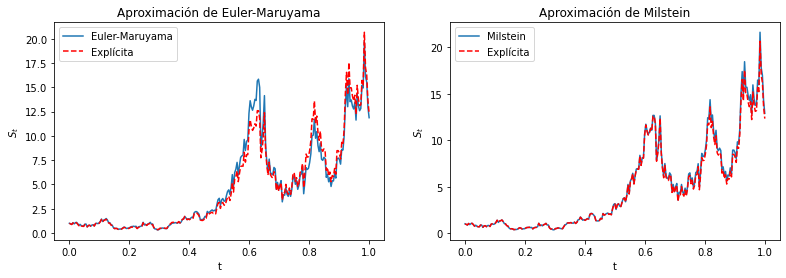

In [64]:
fig, ax = plt.subplots(1,2,figsize=(13, 4))
ax[0].plot(t,em[2], label= 'Euler-Maruyama')
ax[0].plot(t,sol[2], '--r', label= 'Explícita')
ax[0].set_xlabel('t')
ax[0].set_ylabel('$S_t$')
ax[0].set_title('Aproximación de Euler-Maruyama')
ax[0].legend()
ax[1].plot(t,m[2],label= 'Milstein')
ax[1].plot(t,sol[2], '--r', label= 'Explícita')
ax[1].set_xlabel('t')
ax[1].set_ylabel('$S_t$')
ax[1].set_title('Aproximación de Milstein')
ax[1].legend()
plt.show()

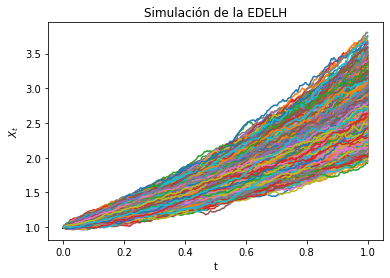

In [11]:
for i in m:
  plt.plot(t,i)
plt.title('Simulación de la EDELH')
plt.xlabel('t')
plt.ylabel('$X_t$')
plt.show()

## Análisis Transversal 

In [12]:
medias= np.zeros(puntos+1)
varianzas= np.zeros(puntos+1)
for i in range(puntos+1):
  medias[i]= np.mean(m[:,i])
  varianzas[i]= np.var(m[:,i])
media_teo= s0*np.exp(mu*t)
var_teo= s0**2*np.exp(2*mu*t)*(np.exp(sigma**2*t)-1)

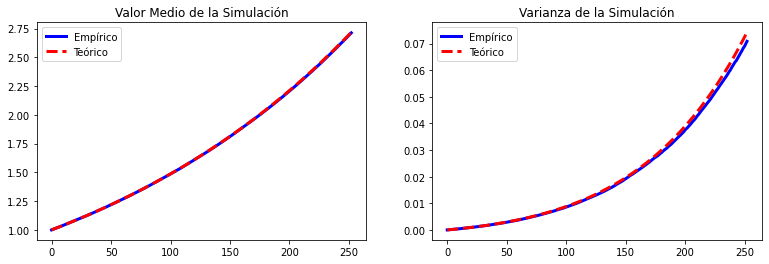

In [13]:
fig, ax = plt.subplots(1,2,figsize=(13, 4))
ax[0].plot(medias, 'b', linewidth=3, label='Empírico')
ax[0].plot(media_teo, '--r', linewidth=3, label='Teórico')
ax[0].set_title('Valor Medio de la Simulación')
ax[0].legend()
ax[1].plot(varianzas, 'b', linewidth=3, label='Empírico')
ax[1].plot(var_teo, '--r', linewidth=3, label='Teórico')
ax[1].set_title('Varianza de la Simulación')
ax[1].legend()
plt.show()

## Análisis longitudinal 

In [14]:
def mediana(St, numTrayectorias):
    I = []
    for i in range(numTrayectorias):
        suma = 0
        for j in range(numTrayectorias):
            suma += np.linalg.norm(St[i,:]-St[j,:],np.inf)
        I.append(suma)
    index = np.argmin(I)
    new_s = St[index,:]
    return new_s

In [15]:
median_m=mediana(m,trayectorias)

In [16]:
rend= np.array([np.log(median_m[j]/median_m[j-1]) for j in range(1,len(median_m))])

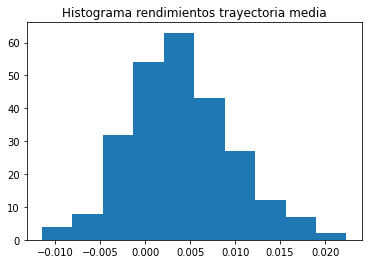

In [17]:
plt.hist(rend)
plt.title('Histograma rendimientos trayectoria media')
plt.show()

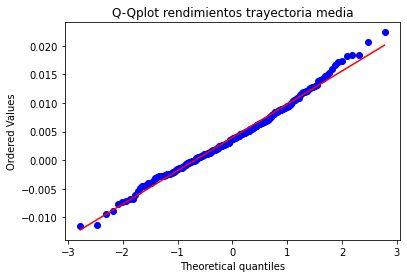

In [18]:
stats.probplot(rend, dist="norm", plot=pylab)
plt.title('Q-Qplot rendimientos trayectoria media')
plt.show()

In [19]:
cont=0
cont2=0
for i in range(trayectorias):
  rendimientos = [np.log(m[i][j]/m[i][j-1]) for j in range(1,len(m[i]))]
  shapiro_test = stats.shapiro(rendimientos)[1]
  if shapiro_test>0.05:
    cont+=1
  chis_test= stats.chisquare(rendimientos)[1]
  if chis_test> 0.5:
    cont2+=1

print(cont,cont2)

9523 10000


Autocorrelación parcial

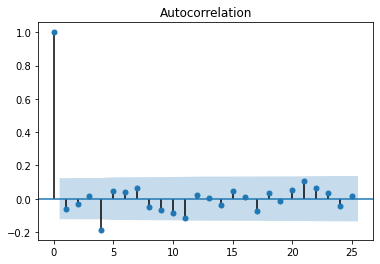

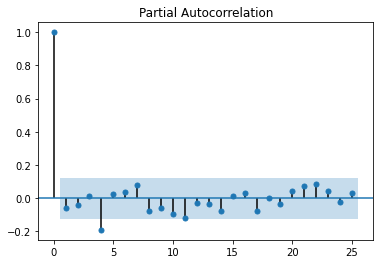

In [20]:
rend= np.array([np.log(median_m[j]/median_m[j-1]) for j in range(1,len(median_m))])
plot_acf(rend)
plot_pacf(rend)
plt.show()

Dimension fractal

In [21]:
def hurst(st):
  lag1=2
  lag2=100
  lags= range(lag1,lag2)
  tau= [np.sqrt(np.std(np.subtract(st[lag:],st[:-lag]))) for lag in lags]
  poly= np.polyfit(np.log(lags),np.log(tau),1)
  return poly[0]*2.0

In [22]:
tipo_serie= np.zeros(3)
for i in m:
  h= hurst(i)
  if h> 0.5001:
    tipo_serie[0]+= 1
  elif h<0.5001:
    tipo_serie[1]+= 1
  else:
    tipo_serie[2]+= 1
tipo_serie

array([6022., 3978.,    0.])

In [89]:
empresa= "AMZN"
data = yf.download(empresa, start="2010-01-01", end="2021-12-31")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,6.812500,6.830500,6.657000,6.695000,6.695000,151998000
2010-01-05,6.671500,6.774000,6.590500,6.734500,6.734500,177038000
2010-01-06,6.730000,6.736500,6.582500,6.612500,6.612500,143576000
2010-01-07,6.600500,6.616000,6.440000,6.500000,6.500000,220604000
2010-01-08,6.528000,6.684000,6.451500,6.676000,6.676000,196610000
...,...,...,...,...,...,...
2021-12-23,170.427994,171.975006,170.149994,171.068497,171.068497,36788000
2021-12-27,171.037003,172.942993,169.215500,169.669495,169.669495,58688000
2021-12-28,170.182495,172.175995,169.135498,170.660995,170.660995,54638000


In [90]:
s_t = data.loc[:,'Close']
s_t = s_t.tolist()

In [107]:
def intervalo(st):
  for i in range(len(st)-252):
    new_st= st[i:i+252]
    rendimientos = [np.log(new_st[j]/new_st[j-1]) for j in range(1,len(new_st))]
    shapiro_test = stats.shapiro(rendimientos)[1]
    if shapiro_test>0.05:
      return i,new_st, rendimientos
i,s_algo,r=intervalo(s_t)

In [108]:
i

2653

In [109]:
data.iloc[i]

Open         1.500100e+02
High         1.600680e+02
Low          1.497010e+02
Close        1.598420e+02
Adj Close    1.598420e+02
Volume       1.519640e+08
Name: 2020-07-20 00:00:00, dtype: float64

In [93]:
data.iloc[i+252]

Open         1.783660e+02
High         1.796000e+02
Low          1.759000e+02
Close        1.786595e+02
Adj Close    1.786595e+02
Volume       6.511400e+07
Name: 2021-07-20 00:00:00, dtype: float64

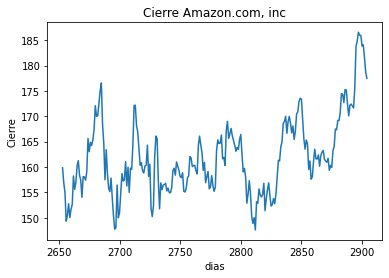

In [113]:
plt.plot(range(i,i+252),s_algo)
plt.xlabel('dias')
plt.ylabel('Cierre')
plt.title('Cierre Amazon.com, inc')
plt.show()

In [119]:
stats.shapiro(r)

ShapiroResult(statistic=0.9892875552177429, pvalue=0.06012750044465065)

In [121]:
stats.chisquare(r)

Power_divergenceResult(statistic=201.05746409902892, pvalue=0.9898348157028225)

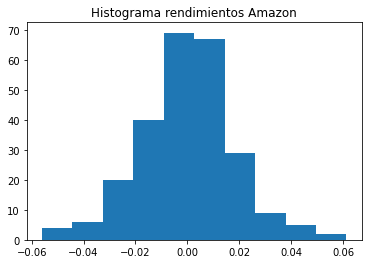

In [115]:
plt.hist(r)
plt.title('Histograma rendimientos Amazon')
plt.show()

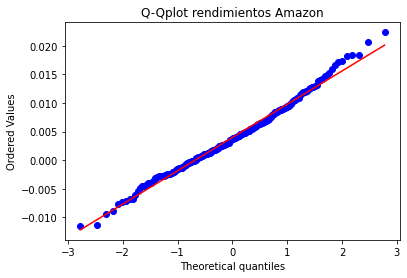

In [117]:
stats.probplot(rend, dist="norm", plot=pylab)
plt.title('Q-Qplot rendimientos Amazon')
plt.show()

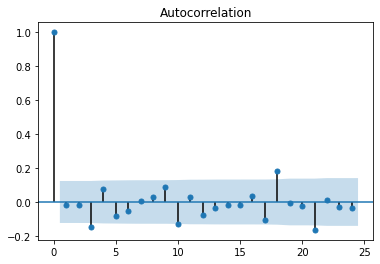

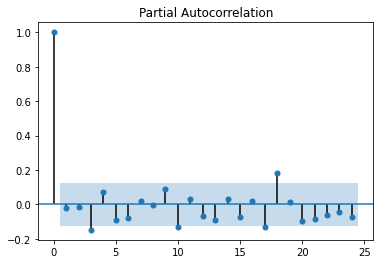

In [118]:
r= np.array(r)
plot_acf(r)
plot_pacf(r)
plt.show()

In [122]:
mu_est= np.mean(r)/delta_t
sigma_est= np.sqrt(np.var(r)/delta_t)
mu_est, sigma_est

(0.10508636307050848, 0.2901325268714109)

In [123]:
dias = 30
trayec=1000
s0_a = s_algo[-1]
last= s_algo.index(s_algo[-1])

In [124]:
mbm= MBEU(trayec,dias)

In [125]:
estim_m= milstein(trayec, dias, mbm, s0_a, mu_est, sigma_est)

In [126]:
upper= []
for i in range(len(estim_m[0])):
  upper.append(np.percentile(estim_m[:,i], 97.5))

In [127]:
lower= []
for i in range(len(estim_m[0])):
  lower.append(np.percentile(estim_m[:,i], 2.5))

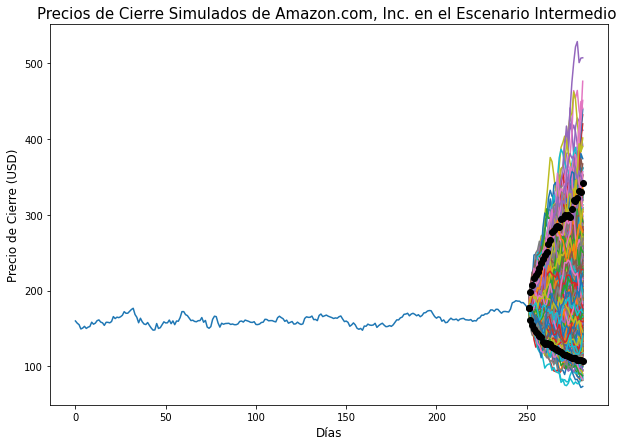

In [129]:
plt.figure(figsize=(10,7))
plt.plot(s_algo)

for Xi in estim_m:
    plt.plot(range(last, last+dias+1), Xi)
    
plt.plot(range(last, last+dias+1), upper, 'ok')
plt.plot(range(last, last+dias+1), lower, 'ok')

plt.title('Precios de Cierre Simulados de Amazon.com, Inc. en el Escenario Intermedio ', fontsize=15)
plt.xlabel('Días', fontsize=12)
plt.ylabel('Precio de Cierre (USD)', fontsize = 12)
plt.show()

In [130]:
means = []
for i in range(len(estim_m[0])):
    means.append(np.mean(estim_m[:, i]))

medians = mediana(estim_m, trayec)

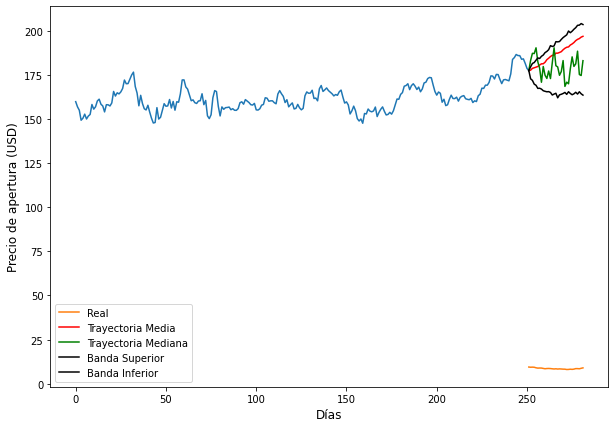

In [131]:
upper2 = []
for i in range(len(estim_m[0])):
    upper2.append(np.percentile(estim_m[:,i], 60.5))

lower2 = []
for i in range(len(estim_m[0])):
    lower2.append(np.percentile(estim_m[:, i], 30.5))

plt.figure(figsize=(10,7))

plt.plot(s_algo)


plt.plot(range(last, last+dias+1),s_t[i+252:i+252 + dias+1], label='Real')
plt.plot(range(last, last+dias+1), means, label='Trayectoria Media', color = 'r')
plt.plot(range(last, last+dias+1), medians, label='Trayectoria Mediana', color = 'green')
plt.plot(range(last, last+dias+1), upper2, label = 'Banda Superior', color = 'black')


plt.plot(range(last, last+dias+1), lower2, label = 'Banda Inferior', color = 'black')

plt.xlabel('Días', fontsize=12)
plt.ylabel('Precio de apertura (USD)', fontsize = 12)
plt.legend()

plt.show()

## Alcista

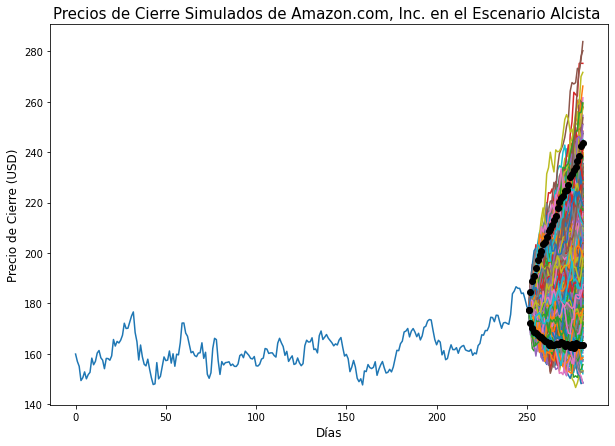

In [133]:
mu_alc = mu_est + mu_est*0.5
m_alcista= milstein(trayec, dias, mb,s0_a, mu_alc, sigma_est)

upper = []
for i in range(len(m_alcista[0])):
    upper.append(np.percentile(m_alcista[:, i], 97.5))
lower = []
for i in range(len(m_alcista[0])):
    lower.append(np.percentile(m_alcista[:, i], 2.5))

plt.figure(figsize=(10,7))
plt.plot(s_algo)

for Xi in m_alcista:
    plt.plot(range(last, last+dias+1), Xi)
    
plt.plot(range(last, last+dias+1), upper, 'ok')
plt.plot(range(last, last+dias+1), lower, 'ok')

plt.title('Precios de Cierre Simulados de Amazon.com, Inc. en el Escenario Alcista ', fontsize=15)
plt.xlabel('Días', fontsize=12)
plt.ylabel('Precio de Cierre (USD)', fontsize = 12)
plt.show()

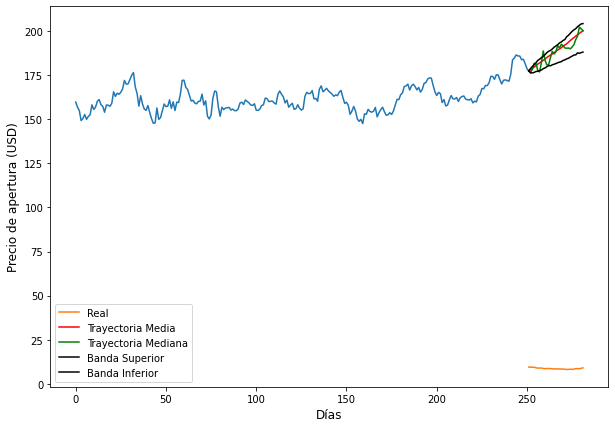

In [134]:
means = []
for i in range(len(m_alcista[0])):
    means.append(np.mean(m_alcista[:, i]))
medians = mediana(m_alcista, trayec)


upper2 = []
for i in range(len(m_alcista[0])):
    upper2.append(np.percentile(m_alcista[:,i], 60.5))

lower2 = []
for i in range(len(m_alcista[0])):
    lower2.append(np.percentile(m_alcista[:, i], 30.5))

plt.figure(figsize=(10,7))

plt.plot(s_algo)


plt.plot(range(last, last+dias+1),s_t[i+252:i+252 + dias+1], label='Real')
plt.plot(range(last, last+dias+1), means, label='Trayectoria Media', color = 'r')
plt.plot(range(last, last+dias+1), medians, label='Trayectoria Mediana', color = 'green')
plt.plot(range(last, last+dias+1), upper2, label = 'Banda Superior', color = 'black')


plt.plot(range(last, last+dias+1), lower2, label = 'Banda Inferior', color = 'black')

plt.xlabel('Días', fontsize=12)
plt.ylabel('Precio de apertura (USD)', fontsize = 12)
plt.legend()

plt.show()

## Bajista

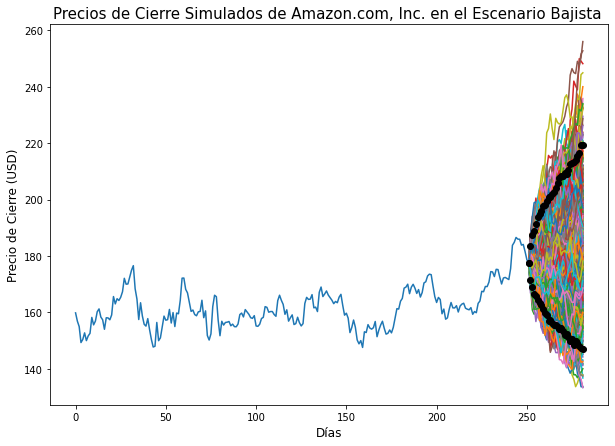

In [136]:
mu_baj = mu_est - mu_est*0.5

m_bajista= milstein(trayec, dias, mb,s0_a, mu_baj, sigma_est)

upper = []
for i in range(len(m_bajista[0])):
    upper.append(np.percentile(m_bajista[:, i], 97.5))
lower = []
for i in range(len(m_bajista[0])):
    lower.append(np.percentile(m_bajista[:, i], 2.5))

plt.figure(figsize=(10,7))
plt.plot(s_algo)

for Xi in m_bajista:
    plt.plot(range(last, last+dias+1), Xi)
    
plt.plot(range(last, last+dias+1), upper, 'ok')
plt.plot(range(last, last+dias+1), lower, 'ok')

plt.title('Precios de Cierre Simulados de Amazon.com, Inc. en el Escenario Bajista ', fontsize=15)
plt.xlabel('Días', fontsize=12)
plt.ylabel('Precio de Cierre (USD)', fontsize = 12)
plt.show()


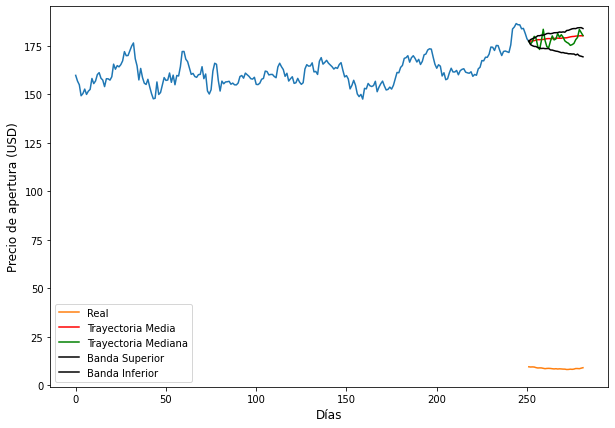

In [137]:
means = []
for i in range(len(m_bajista[0])):
    means.append(np.mean(m_bajista[:, i]))
medians = mediana(m_bajista, trayec)


upper2 = []
for i in range(len(m_bajista[0])):
    upper2.append(np.percentile(m_bajista[:,i], 60.5))

lower2 = []
for i in range(len(m_bajista[0])):
    lower2.append(np.percentile(m_bajista[:, i], 30.5))

plt.figure(figsize=(10,7))

plt.plot(s_algo)


plt.plot(range(last, last+dias+1),s_t[i+252:i+252 + dias+1], label='Real')
plt.plot(range(last, last+dias+1), means, label='Trayectoria Media', color = 'r')
plt.plot(range(last, last+dias+1), medians, label='Trayectoria Mediana', color = 'green')
plt.plot(range(last, last+dias+1), upper2, label = 'Banda Superior', color = 'black')
plt.plot(range(last, last+dias+1), lower2, label = 'Banda Inferior', color = 'black')

plt.xlabel('Días', fontsize=12)
plt.ylabel('Precio de apertura (USD)', fontsize = 12)
plt.legend()

plt.show()